In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import keras
import numpy as np
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import pad_sequences

In [3]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [5]:
final_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
final_df.drop(['date_column.2', 'ppid.2', 'date_column.1', 'ppid.1'], axis=1, inplace=True)

In [7]:
final_df['date_column'] = pd.to_datetime(final_df['date_column'])

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest


# Replace 'target_column' with the name of your target variable column
target_column = 'blood_culture_test_encoded'  # Change this to your actual target column name

# Drop the date column - replace 'date_column' with your actual date column name
X = final_df.drop([target_column, 'date_column', 'ppid'], axis=1)
y = final_df[target_column]
feature_names = list(X.columns)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=False)


scaler = StandardScaler().fit(X_train_xgb)
X_train_xgb_2d = scaler.transform(X_train_xgb)
X_test_xgb_2d = scaler.transform(X_test_xgb)

# Fill NaN values, if they exist
X_train_xgb_2d = np.nan_to_num(X_train_xgb_2d)
X_test_xgb_2d = np.nan_to_num(X_test_xgb_2d)

# For example:
iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
iso_forest.fit(X_train_xgb_2d[y_train_xgb == 0])  # Assuming y_train_xgb is your target variable for XGBoost

# Compute anomaly scores for each subset using the same Isolation Forest model
anomaly_scores_train_xgb = iso_forest.decision_function(X_train_xgb_2d)
anomaly_scores_test_xgb = iso_forest.decision_function(X_test_xgb_2d)

# Normalize the anomaly scores
anomaly_scores_train_xgb_norm = np.interp(anomaly_scores_train_xgb, (anomaly_scores_train_xgb.min(), anomaly_scores_train_xgb.max()), (0, 1))
anomaly_scores_test_xgb_norm = np.interp(anomaly_scores_test_xgb, (anomaly_scores_test_xgb.min(), anomaly_scores_test_xgb.max()), (0, 1))

# Append anomaly scores to the original 2D data
X_train_xgb_extended = np.concatenate((X_train_xgb_2d, anomaly_scores_train_xgb_norm.reshape(-1, 1)), axis=1)
X_test_xgb_extended = np.concatenate((X_test_xgb_2d, anomaly_scores_test_xgb_norm.reshape(-1, 1)), axis=1)

feature_names.append('anomaly_score')
class_ratio = sum(y_train_xgb == 0) / sum(y_train_xgb == 1)

# Now, X_train_xgb_extended and X_test_xgb_extended are ready for training with XGBoost


In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight=class_ratio, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_xgb_extended, y_train_xgb)
y_pred_xgb = xgb_model.predict(X_test_xgb_extended)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(scale_pos_weight=class_ratio)
lgb_model.fit(X_train_xgb_extended, y_train_xgb)
y_pred_lgb = lgb_model.predict(X_test_xgb_extended)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 4223, number of negative: 44698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7578
[LightGBM] [Info] Number of data points in the train set: 48921, number of used features: 163
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086323 -> initscore=-2.359383
[LightGBM] [Info] Start training from score -2.359383


In [12]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.5 MB/s eta 0:00:00


In [13]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(scale_pos_weight=class_ratio, verbose=0)
cat_model.fit(X_train_xgb_extended, y_train_xgb)
y_pred_cat = cat_model.predict(X_test_xgb_extended)


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_xgb_extended.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_nn.fit(X_train_xgb_extended, y_train_xgb, epochs=10, batch_size=32)
y_pred_nn = model_nn.predict(X_test_xgb_extended)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9078 - loss: 0.2785
Epoch 2/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9220 - loss: 0.2291
Epoch 3/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9250 - loss: 0.2191
Epoch 4/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9267 - loss: 0.2100
Epoch 5/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9303 - loss: 0.1999
Epoch 6/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9356 - loss: 0.1847
Epoch 7/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9406 - loss: 0.1726
Epoch 8/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9431 - loss: 0.1641
Epoch 9/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9488 - loss: 0.1506
Epoch 10/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9509 - loss: 0.1432
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [15]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_xgb_extended, y_train_xgb)
y_pred_log = log_reg.predict(X_test_xgb_extended)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_xgb_extended, y_train_xgb)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_xgb_extended)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, average_precision_score


In [18]:
def evaluate_model(y_true, y_pred, y_scores):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # same as sensitivity
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    auprc = average_precision_score(y_true, y_scores)

    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"AUPRC Score: {auprc:.4f}")

In [ ]:
combined_predictions = np.round((y_pred_xgb + y_pred_lgb + y_pred_cat) / 3).astype(int)


In [19]:
y_scores_xgb = xgb_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_lgb = lgb_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_cat = cat_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_rf = rf_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_nn = model_nn.predict(X_test_xgb_extended).ravel()
y_scores_log = log_reg.predict_proba(X_test_xgb_extended)[:, 1]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [20]:

print("\nLightGBM Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_lgb, y_scores_lgb)

print("\nCatBoost Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_cat, y_scores_cat)

# For Neural Network, convert predictions to binary first (assuming threshold of 0.5)
y_pred_nn_binary = np.round(y_pred_nn).astype(int).flatten()
print("\nNeural Network Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_nn_binary, y_scores_nn)

print("\nLogistic Regression Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_log, y_scores_log)


print("\nRandom Forest Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_rf, y_scores_rf)


print("XGBoost Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_xgb, y_scores_xgb)

print("\nLogistic Regression Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_log, y_scores_log)




LightGBM Model Evaluation:
Accuracy: 0.8024
Precision: 0.2515
Recall (Sensitivity): 0.6423
Specificity: 0.8177
F1 Score: 0.3614
ROC AUC Score: 0.8001
AUPRC Score: 0.3758

CatBoost Model Evaluation:
Accuracy: 0.8328
Precision: 0.2744
Recall (Sensitivity): 0.5596
Specificity: 0.8589
F1 Score: 0.3682
ROC AUC Score: 0.7927
AUPRC Score: 0.3702

Neural Network Model Evaluation:
Accuracy: 0.8928
Precision: 0.3553
Recall (Sensitivity): 0.2836
Specificity: 0.9509
F1 Score: 0.3154
ROC AUC Score: 0.7255
AUPRC Score: 0.2628

Logistic Regression Model Evaluation:
Accuracy: 0.9151
Precision: 0.5789
Recall (Sensitivity): 0.0930
Specificity: 0.9936
F1 Score: 0.1602
ROC AUC Score: 0.7625
AUPRC Score: 0.3164

Random Forest Model Evaluation:
Accuracy: 0.9149
Precision: 0.7308
Recall (Sensitivity): 0.0357
Specificity: 0.9987
F1 Score: 0.0680
ROC AUC Score: 0.7683
AUPRC Score: 0.3381
XGBoost Model Evaluation:
Accuracy: 0.8371
Precision: 0.2763
Recall (Sensitivity): 0.5380
Specificity: 0.8656
F1 Score: 0.3

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# Assuming final_df is your DataFrame
# Replace 'target_column' and 'date_column' with your actual column names
target_column = 'blood_culture_test_encoded'
X = final_df.drop([target_column, 'date_column', 'ppid'], axis=1)
y = final_df[target_column]

# Initialize the KFold for 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for results
results = {"XGB": []}

# Function to evaluate the model
def evaluate_model(y_true, y_pred, y_scores):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    auprc = average_precision_score(y_true, y_scores)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return accuracy, precision, recall, f1, roc_auc, auprc, specificity

# Loop over each fold
for train_index, test_index in kf.split(X):
    # Split data into train and test for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle NaNs
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    # Train the Isolation Forest for anomaly detection
    iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
    iso_forest.fit(X_train_scaled[y_train == 0])

    # Compute and normalize anomaly scores
    anomaly_scores_train = np.interp(
        iso_forest.decision_function(X_train_scaled),
        (iso_forest.decision_function(X_train_scaled).min(), iso_forest.decision_function(X_train_scaled).max()),
        (0, 1)
    )
    anomaly_scores_test = np.interp(
        iso_forest.decision_function(X_test_scaled),
        (iso_forest.decision_function(X_test_scaled).min(), iso_forest.decision_function(X_test_scaled).max()),
        (0, 1)
    )

    # Append anomaly scores to the scaled data
    X_train_extended = np.concatenate((X_train_scaled, anomaly_scores_train.reshape(-1, 1)), axis=1)
    X_test_extended = np.concatenate((X_test_scaled, anomaly_scores_test.reshape(-1, 1)), axis=1)

    # Calculate class ratio
    class_ratio = sum(y_train == 0) / sum(y_train == 1)

    # Train XGBoost
    xgb_model = XGBClassifier(scale_pos_weight=class_ratio, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_extended, y_train)

    # Predict and evaluate
    y_pred = xgb_model.predict(X_test_extended)
    y_scores = xgb_model.predict_proba(X_test_extended)[:, 1]
    accuracy, precision, recall, f1, roc_auc, auprc, specificity = evaluate_model(y_test, y_pred, y_scores)

    # Store results
    results["XGB"].append((accuracy, precision, recall, f1, roc_auc, auprc, specificity))

# After the loop, results contain the metrics for each fold
print("XGBoost Results:", results["XGB"])


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Results: [(0.8499713841877198, 0.292, 0.5822532402791625, 0.38894438894438893, 0.7987194455109912, 0.40592089442270984, 0.8738867117919487), (0.8578202926988799, 0.3065934065934066, 0.5391304347826087, 0.3908931698774081, 0.7926740571598208, 0.40711216451525656, 0.8872811718470882), (0.8524121013900245, 0.31347962382445144, 0.5499541704857929, 0.39933444259567386, 0.7867387595906045, 0.40211628123873655, 0.8820360894155669), (0.852085036794767, 0.3191489361702128, 0.5530575539568345, 0.4047384007897335, 0.7994786308028591, 0.4335907947045021, 0.8819931642381723), (0.8494685200327065, 0.28701716738197425, 0.5109837631327603, 0.3675712813466163, 0.7657935392964539, 0.3927492230190799, 0.8811589019046767)]


In [23]:
# After the loop, process and print the results in a readable format
print("XGBoost Results:")
print("Fold\tAccuracy\tPrecision\tRecall\t\tF1 Score\tROC AUC\t\tAUPRC\t\tSpecificity")

for i, (accuracy, precision, recall, f1, roc_auc, auprc, specificity) in enumerate(results["XGB"]):
    print(f"{i+1}\t{accuracy:.4f}\t\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}\t\t{roc_auc:.4f}\t\t{auprc:.4f}\t\t{specificity:.4f}")


XGBoost Results:
Fold	Accuracy	Precision	Recall		F1 Score	ROC AUC		AUPRC		Specificity
1	0.8500		0.2920		0.5823		0.3889		0.7987		0.4059		0.8739
2	0.8578		0.3066		0.5391		0.3909		0.7927		0.4071		0.8873
3	0.8524		0.3135		0.5500		0.3993		0.7867		0.4021		0.8820
4	0.8521		0.3191		0.5531		0.4047		0.7995		0.4336		0.8820
5	0.8495		0.2870		0.5110		0.3676		0.7658		0.3927		0.8812


In [24]:
from lightgbm import LGBMClassifier

results["LGBM"] = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Scale the features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle NaNs
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    # Train the Isolation Forest for anomaly detection
    iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
    iso_forest.fit(X_train_scaled[y_train == 0])

    # Compute and normalize anomaly scores
    anomaly_scores_train = np.interp(
        iso_forest.decision_function(X_train_scaled),
        (iso_forest.decision_function(X_train_scaled).min(), iso_forest.decision_function(X_train_scaled).max()),
        (0, 1)
    )
    anomaly_scores_test = np.interp(
        iso_forest.decision_function(X_test_scaled),
        (iso_forest.decision_function(X_test_scaled).min(), iso_forest.decision_function(X_test_scaled).max()),
        (0, 1)
    )

    # Append anomaly scores to the scaled data
    X_train_extended = np.concatenate((X_train_scaled, anomaly_scores_train.reshape(-1, 1)), axis=1)
    X_test_extended = np.concatenate((X_test_scaled, anomaly_scores_test.reshape(-1, 1)), axis=1)

    class_ratio = sum(y_train == 0) / sum(y_train == 1)

    # Train LightGBM
    lgb_model = LGBMClassifier(scale_pos_weight=class_ratio)
    lgb_model.fit(X_train_extended, y_train)

    # Predict and evaluate
    y_pred = lgb_model.predict(X_test_extended)
    y_scores = lgb_model.predict_proba(X_test_extended)[:, 1]
    accuracy, precision, recall, f1, roc_auc, auprc, specificity = evaluate_model(y_test, y_pred, y_scores)

    # Store results
    results["LGBM"].append((accuracy, precision, recall, f1, roc_auc, auprc, specificity))

# Print results for LightGBM
print("LightGBM Results:")
for i, metrics in enumerate(results["LGBM"]):
    print(f"Fold {i+1}: {metrics}")


[LightGBM] [Info] Number of positive: 4285, number of negative: 44636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7698
[LightGBM] [Info] Number of data points in the train set: 48921, number of used features: 163
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087590 -> initscore=-2.343420
[LightGBM] [Info] Start training from score -2.343420
[LightGBM] [Info] Number of positive: 4253, number of negative: 44668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7682
[LightGBM] [Info] Number of data points in the train set: 48921, number of used features: 164
[LightGBM] [Info] 

In [25]:
# After the loop, process and print the results in a readable format
print("LGBM Results:")
print("Fold\tAccuracy\tPrecision\tRecall\t\tF1 Score\tROC AUC\t\tAUPRC\t\tSpecificity")

for i, (accuracy, precision, recall, f1, roc_auc, auprc, specificity) in enumerate(results["LGBM"]):
    print(f"{i+1}\t{accuracy:.4f}\t\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}\t\t{roc_auc:.4f}\t\t{auprc:.4f}\t\t{specificity:.4f}")


LGBM Results:
Fold	Accuracy	Precision	Recall		F1 Score	ROC AUC		AUPRC		Specificity
1	0.8015		0.2438		0.6760		0.3584		0.8100		0.4079		0.8127
2	0.8084		0.2513		0.6386		0.3607		0.8066		0.4051		0.8241
3	0.8025		0.2524		0.6187		0.3586		0.7915		0.3923		0.8205
4	0.8046		0.2659		0.6529		0.3779		0.8144		0.4319		0.8198
5	0.8050		0.2456		0.6170		0.3514		0.7954		0.3779		0.8226


In [26]:
!pip install catboost

In [27]:
from catboost import CatBoostClassifier

results["CatBoost"] = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Scale the features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle NaNs
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    # Train the Isolation Forest for anomaly detection
    iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
    iso_forest.fit(X_train_scaled[y_train == 0])

    # Compute and normalize anomaly scores
    anomaly_scores_train = np.interp(
        iso_forest.decision_function(X_train_scaled),
        (iso_forest.decision_function(X_train_scaled).min(), iso_forest.decision_function(X_train_scaled).max()),
        (0, 1)
    )
    anomaly_scores_test = np.interp(
        iso_forest.decision_function(X_test_scaled),
        (iso_forest.decision_function(X_test_scaled).min(), iso_forest.decision_function(X_test_scaled).max()),
        (0, 1)
    )

    # Append anomaly scores to the scaled data
    X_train_extended = np.concatenate((X_train_scaled, anomaly_scores_train.reshape(-1, 1)), axis=1)
    X_test_extended = np.concatenate((X_test_scaled, anomaly_scores_test.reshape(-1, 1)), axis=1)

    class_ratio = sum(y_train == 0) / sum(y_train == 1)

    # Train CatBoost
    cat_model = CatBoostClassifier(scale_pos_weight=class_ratio, verbose=0)
    cat_model.fit(X_train_extended, y_train)

    # Predict and evaluate
    y_pred = cat_model.predict(X_test_extended)
    y_scores = cat_model.predict_proba(X_test_extended)[:, 1]
    accuracy, precision, recall, f1, roc_auc, auprc, specificity = evaluate_model(y_test, y_pred, y_scores)

    # Store results
    results["CatBoost"].append((accuracy, precision, recall, f1, roc_auc, auprc, specificity))

# Print results for CatBoost
print("CatBoost Results:")
for i, metrics in enumerate(results["CatBoost"]):
    print(f"Fold {i+1}: {metrics}")
# After the loop, process and print the results in a readable format

print("CatBoost Results:")
print("Fold\tAccuracy\tPrecision\tRecall\t\tF1 Score\tROC AUC\t\tAUPRC\t\tSpecificity")

for i, (accuracy, precision, recall, f1, roc_auc, auprc, specificity) in enumerate(results["CatBoost"]):
    print(f"{i+1}\t{accuracy:.4f}\t\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}\t\t{roc_auc:.4f}\t\t{auprc:.4f}\t\t{specificity:.4f}")


CatBoost Results:
Fold 1: (0.847682119205298, 0.2981220657276995, 0.6331006979062812, 0.4053622725821896, 0.8176533811461945, 0.44060616726470064, 0.8668507303170645)
Fold 2: (0.849726105796746, 0.2991495747873937, 0.5777777777777777, 0.39419907712590635, 0.8131922546527142, 0.4251758755497025, 0.87486602357985)
Fold 3: (0.8441537203597711, 0.3036144578313253, 0.5774518790100825, 0.3979785217940619, 0.8027084465288186, 0.4061645261164733, 0.8702756082233594)
Fold 4: (0.8480784955028619, 0.3218720152817574, 0.6061151079136691, 0.4204616344354336, 0.8181109995975158, 0.44903207350404034, 0.8722791869041194)
Fold 5: (0.8480784955028619, 0.3001478560867422, 0.5816618911174785, 0.39596879063719115, 0.8001654510218599, 0.40731063642636006, 0.8730215505678262)
CatBoost Results:
Fold	Accuracy	Precision	Recall		F1 Score	ROC AUC		AUPRC		Specificity
1	0.8477		0.2981		0.6331		0.4054		0.8177		0.4406		0.8669
2	0.8497		0.2991		0.5778		0.3942		0.8132		0.4252		0.8749
3	0.8442		0.3036		0.5775		0.3980		0

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

results["NeuralNetwork"] = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Scale the features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle NaNs
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    # Train the Isolation Forest for anomaly detection
    iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
    iso_forest.fit(X_train_scaled[y_train == 0])

    # Compute and normalize anomaly scores
    anomaly_scores_train = np.interp(
        iso_forest.decision_function(X_train_scaled),
        (iso_forest.decision_function(X_train_scaled).min(), iso_forest.decision_function(X_train_scaled).max()),
        (0, 1)
    )
    anomaly_scores_test = np.interp(
        iso_forest.decision_function(X_test_scaled),
        (iso_forest.decision_function(X_test_scaled).min(), iso_forest.decision_function(X_test_scaled).max()),
        (0, 1)
    )

    # Append anomaly scores to the scaled data
    X_train_extended = np.concatenate((X_train_scaled, anomaly_scores_train.reshape(-1, 1)), axis=1)
    X_test_extended = np.concatenate((X_test_scaled, anomaly_scores_test.reshape(-1, 1)), axis=1)

    # Define Neural Network model
    model_nn = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_extended.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train Neural Network
    model_nn.fit(X_train_extended, y_train, epochs=10, batch_size=32)

    # Predict and evaluate
    y_pred_prob = model_nn.predict(X_test_extended)
    y_pred = (y_pred_prob > 0.5).astype(int)
    accuracy, precision, recall, f1, roc_auc, auprc, specificity = evaluate_model(y_test, y_pred, y_pred_prob)

    # Store results
    results["NeuralNetwork"].append((accuracy, precision, recall, f1, roc_auc, auprc, specificity))

# Print results for Neural Network
print("Neural Network Results:")
for i, metrics in enumerate(results["NeuralNetwork"]):
    print(f"Fold {i+1}: {metrics}")

print("NeuralNetwork Results:")
print("Fold\tAccuracy\tPrecision\tRecall\t\tF1 Score\tROC AUC\t\tAUPRC\t\tSpecificity")

for i, (accuracy, precision, recall, f1, roc_auc, auprc, specificity) in enumerate(results["NeuralNetwork"]):
    print(f"{i+1}\t{accuracy:.4f}\t\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}\t\t{roc_auc:.4f}\t\t{auprc:.4f}\t\t{specificity:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9128 - loss: 0.2863
Epoch 2/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9190 - loss: 0.2402
Epoch 3/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9228 - loss: 0.2258
Epoch 4/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9249 - loss: 0.2171
Epoch 5/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9319 - loss: 0.1975
Epoch 6/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9349 - loss: 0.1907
Epoch 7/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9366 - loss: 0.1854
Epoch 8/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9424 - loss: 0.1685
Epoch 9/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9441 - loss: 0.1610
Epoch 10/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9497 - loss: 0.1460
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1529/1529 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9138 - loss: 0.2806
Epoch 2/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9196 - loss: 0.2382
Epoch 3/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9212 - loss: 0.2258
Epoch 4/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9247 - loss: 0.2130
Epoch 5/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9278 - loss: 0.2034
Epoch 6/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9334 - loss: 0.1860
Epoch 7/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9368 - loss: 0.1758
Epoch 8/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9420 - loss: 0.1617
Epoch 9/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9453 - loss: 0.1542
Epoch 10/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9509 - loss: 0.1398
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1529/1529 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9062 - loss: 0.2808
Epoch 2/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9199 - loss: 0.2319
Epoch 3/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9238 - loss: 0.2204
Epoch 4/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9264 - loss: 0.2116
Epoch 5/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9293 - loss: 0.2020
Epoch 6/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9353 - loss: 0.1850
Epoch 7/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9386 - loss: 0.1724
Epoch 8/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9393 - loss: 0.1693
Epoch 9/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9460 - loss: 0.1540
Epoch 10/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9497 - loss: 0.1418
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1529/1529 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9031 - loss: 0.2919
Epoch 2/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9218 - loss: 0.2325
Epoch 3/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9246 - loss: 0.2205
Epoch 4/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9276 - loss: 0.2090
Epoch 5/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9336 - loss: 0.1927
Epoch 6/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9363 - loss: 0.1857
Epoch 7/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9399 - loss: 0.1729
Epoch 8/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9426 - loss: 0.1644
Epoch 9/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9484 - loss: 0.1501
Epoch 10/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9488 - loss: 0.1446
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1529/1529 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9096 - loss: 0.2813
Epoch 2/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9198 - loss: 0.2393
Epoch 3/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9234 - loss: 0.2205
Epoch 4/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9289 - loss: 0.2079
Epoch 5/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9276 - loss: 0.2023
Epoch 6/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9337 - loss: 0.1898
Epoch 7/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9390 - loss: 0.1740
Epoch 8/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9412 - loss: 0.1663
Epoch 9/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9462 - loss: 0.1547
Epoch 10/10
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9490 - loss: 0.1454
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neural Network Results:
Fold 1: (0.9203662823971874, 0.5241264559068219, 0.31405782652043

In [29]:
from sklearn.linear_model import LogisticRegression

results["LogisticRegression"] = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Scale the features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle NaNs
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    # Train the Isolation Forest for anomaly detection
    iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
    iso_forest.fit(X_train_scaled[y_train == 0])

    # Compute and normalize anomaly scores
    anomaly_scores_train = np.interp(
        iso_forest.decision_function(X_train_scaled),
        (iso_forest.decision_function(X_train_scaled).min(), iso_forest.decision_function(X_train_scaled).max()),
        (0, 1)
    )
    anomaly_scores_test = np.interp(
        iso_forest.decision_function(X_test_scaled),
        (iso_forest.decision_function(X_test_scaled).min(), iso_forest.decision_function(X_test_scaled).max()),
        (0, 1)
    )

    # Append anomaly scores to the scaled data
    X_train_extended = np.concatenate((X_train_scaled, anomaly_scores_train.reshape(-1, 1)), axis=1)
    X_test_extended = np.concatenate((X_test_scaled, anomaly_scores_test.reshape(-1, 1)), axis=1)

    # Train Logistic Regression
    log_reg = LogisticRegression(class_weight={0: 1, 1: class_ratio}, max_iter=1000)
    log_reg.fit(X_train_extended, y_train)

    # Predict and evaluate
    y_pred = log_reg.predict(X_test_extended)
    y_scores = log_reg.predict_proba(X_test_extended)[:, 1]
    accuracy, precision, recall, f1, roc_auc, auprc, specificity = evaluate_model(y_test, y_pred, y_scores)

    # Store results
    results["LogisticRegression"].append((accuracy, precision, recall, f1, roc_auc, auprc, specificity))

# Print results for Logistic Regression
print("Logistic Regression Results:")
for i, metrics in enumerate(results["LogisticRegression"]):
    print(f"Fold {i+1}: {metrics}")

print("LogisticRegression Results:")
print("Fold\tAccuracy\tPrecision\tRecall\t\tF1 Score\tROC AUC\t\tAUPRC\t\tSpecificity")

for i, (accuracy, precision, recall, f1, roc_auc, auprc, specificity) in enumerate(results["LogisticRegression"]):
    print(f"{i+1}\t{accuracy:.4f}\t\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}\t\t{roc_auc:.4f}\t\t{auprc:.4f}\t\t{specificity:.4f}")


Logistic Regression Results:
Fold 1: (0.7419671326956095, 0.192867332382311, 0.6739780658025922, 0.29991126885536823, 0.7748470832603721, 0.30336868618870405, 0.7480406127538297)
Fold 2: (0.7522688251165073, 0.1996386630532972, 0.6405797101449275, 0.3044077134986226, 0.7678913103886308, 0.2971520567850381, 0.762593783494105)
Fold 3: (0.7443990188062142, 0.2018751831233519, 0.6315307057745188, 0.3059502664298402, 0.7562607131992375, 0.281624941294882, 0.7554538109345542)
Fold 4: (0.7497138184791496, 0.21497513892951156, 0.6609712230215827, 0.32443169278305006, 0.777069332121998, 0.3154117291493242, 0.7585896744018709)
Fold 5: (0.749795584627964, 0.20370915513688548, 0.6609360076408787, 0.3114311431143114, 0.7691380891705167, 0.29496228688098686, 0.758114995976035)
LogisticRegression Results:
Fold	Accuracy	Precision	Recall		F1 Score	ROC AUC		AUPRC		Specificity
1	0.7420		0.1929		0.6740		0.2999		0.7748		0.3034		0.7480
2	0.7523		0.1996		0.6406		0.3044		0.7679		0.2972		0.7626
3	0.7444		0.201

In [30]:
from sklearn.ensemble import RandomForestClassifier

results["RandomForest"] = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Scale the features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle NaNs
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    # Train the Isolation Forest for anomaly detection
    iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
    iso_forest.fit(X_train_scaled[y_train == 0])

    # Compute and normalize anomaly scores
    anomaly_scores_train = np.interp(
        iso_forest.decision_function(X_train_scaled),
        (iso_forest.decision_function(X_train_scaled).min(), iso_forest.decision_function(X_train_scaled).max()),
        (0, 1)
    )
    anomaly_scores_test = np.interp(
        iso_forest.decision_function(X_test_scaled),
        (iso_forest.decision_function(X_test_scaled).min(), iso_forest.decision_function(X_test_scaled).max()),
        (0, 1)
    )

    # Append anomaly scores to the scaled data
    X_train_extended = np.concatenate((X_train_scaled, anomaly_scores_train.reshape(-1, 1)), axis=1)
    X_test_extended = np.concatenate((X_test_scaled, anomaly_scores_test.reshape(-1, 1)), axis=1)

    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: class_ratio})
    rf_model.fit(X_train_extended, y_train)

    # Predict and evaluate
    y_pred = rf_model.predict(X_test_extended)
    y_scores = rf_model.predict_proba(X_test_extended)[:, 1]
    accuracy, precision, recall, f1, roc_auc, auprc, specificity = evaluate_model(y_test, y_pred, y_scores)

    # Store results
    results["RandomForest"].append((accuracy, precision, recall, f1, roc_auc, auprc, specificity))

# Print results for Random Forest
print("Random Forest Results:")
for i, metrics in enumerate(results["RandomForest"]):
    print(f"Fold {i+1}: {metrics}")

print("RandomForest Results:")
print("Fold\tAccuracy\tPrecision\tRecall\t\tF1 Score\tROC AUC\t\tAUPRC\t\tSpecificity")

for i, (accuracy, precision, recall, f1, roc_auc, auprc, specificity) in enumerate(results["RandomForest"]):
    print(f"{i+1}\t{accuracy:.4f}\t\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}\t\t{roc_auc:.4f}\t\t{auprc:.4f}\t\t{specificity:.4f}")


Random Forest Results:
Fold 1: (0.925844166462268, 0.8, 0.12761714855433698, 0.22012037833190026, 0.8406901667636919, 0.4676550657218328, 0.9971499821873887)
Fold 2: (0.9239636987981359, 0.9007633587786259, 0.11400966183574879, 0.20240137221269297, 0.8338361440334972, 0.46916537450151474, 0.9988388710253662)
Fold 3: (0.9174161896974653, 0.8403361344537815, 0.09165902841429881, 0.16528925619834708, 0.8267167512202482, 0.4539136618265392, 0.9982942813538019)
Fold 4: (0.9184791496320523, 0.9078014184397163, 0.11510791366906475, 0.20430965682362331, 0.8386383850286204, 0.5074155590861709, 0.9988307249505307)
Fold 5: (0.9219950940310712, 0.8974358974358975, 0.10028653295128939, 0.18041237113402062, 0.8349687977239979, 0.4555261502968155, 0.9989269426808549)
RandomForest Results:
Fold	Accuracy	Precision	Recall		F1 Score	ROC AUC		AUPRC		Specificity
1	0.9258		0.8000		0.1276		0.2201		0.8407		0.4677		0.9971
2	0.9240		0.9008		0.1140		0.2024		0.8338		0.4692		0.9988
3	0.9174		0.8403		0.0917		0.1653

In [31]:

# Calculate the scale_pos_weight value
class_ratio = sum(y_train_xgb == 0) / sum(y_train_xgb == 1)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=class_ratio, random_state=42)

# Proceed with training the model
xgb_model.fit(X_train_xgb_extended, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [32]:
xgb_preds = xgb_model.predict_proba(X_test_xgb_extended)[:, 1]  # Gets the probability for class 1

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, precision_recall_curve, auc

# Assuming y_test are the true labels and combined_preds are your model predictions
true_labels = y_test_xgb
predictions = xgb_preds.round()  # Ensure these are binary (0 or 1)

# Accuracy
accuracy = accuracy_score(true_labels, predictions)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# F1 Score
f1 = f1_score(true_labels, predictions)

# Precision-Recall Curve and AUPRC
precision, recall, _ = precision_recall_curve(true_labels, predictions)
auprc = auc(recall, precision)

# AUC-ROC
auc_roc = roc_auc_score(true_labels, xgb_preds)  # Use the prediction probabilities here

# Printing metrics
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"AUPRC: {auprc}")
print(f"AUC-ROC: {auc_roc}")

Accuracy: 0.8370533889297687
Sensitivity: 0.5380281690140845
Specificity: 0.8655740641232312
F1 Score: 0.36508442179037903
AUPRC: 0.4272657746691081
AUC-ROC: 0.7775855443125047


In [21]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 15.0 MB/s eta 0:00:00


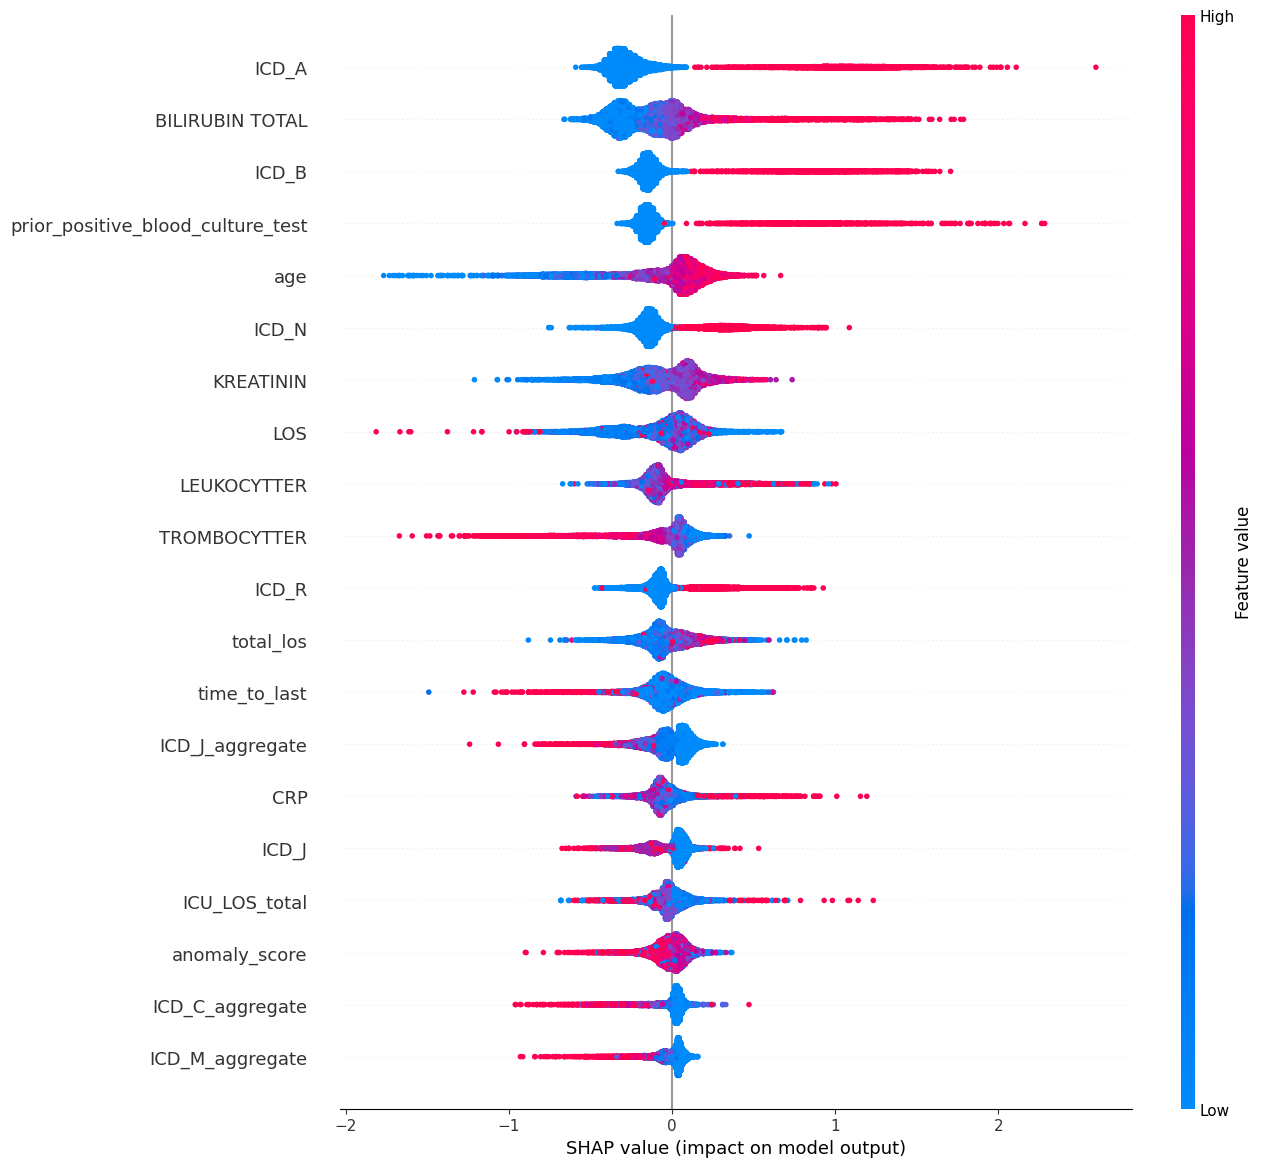

In [33]:
import shap
import matplotlib.pyplot as plt

# Generate SHAP values
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_xgb_extended)


# Plot SHAP summary dot plot
shap.summary_plot(shap_values, features=X_test_xgb_extended, feature_names=feature_names, show = False,)
# Save the plot as a high-quality PNG file
plt.gcf().set_size_inches(18, 12)  # Adjust the size as needed

plt.savefig("shap_summary_plot.png", bbox_inches='tight', dpi=300)

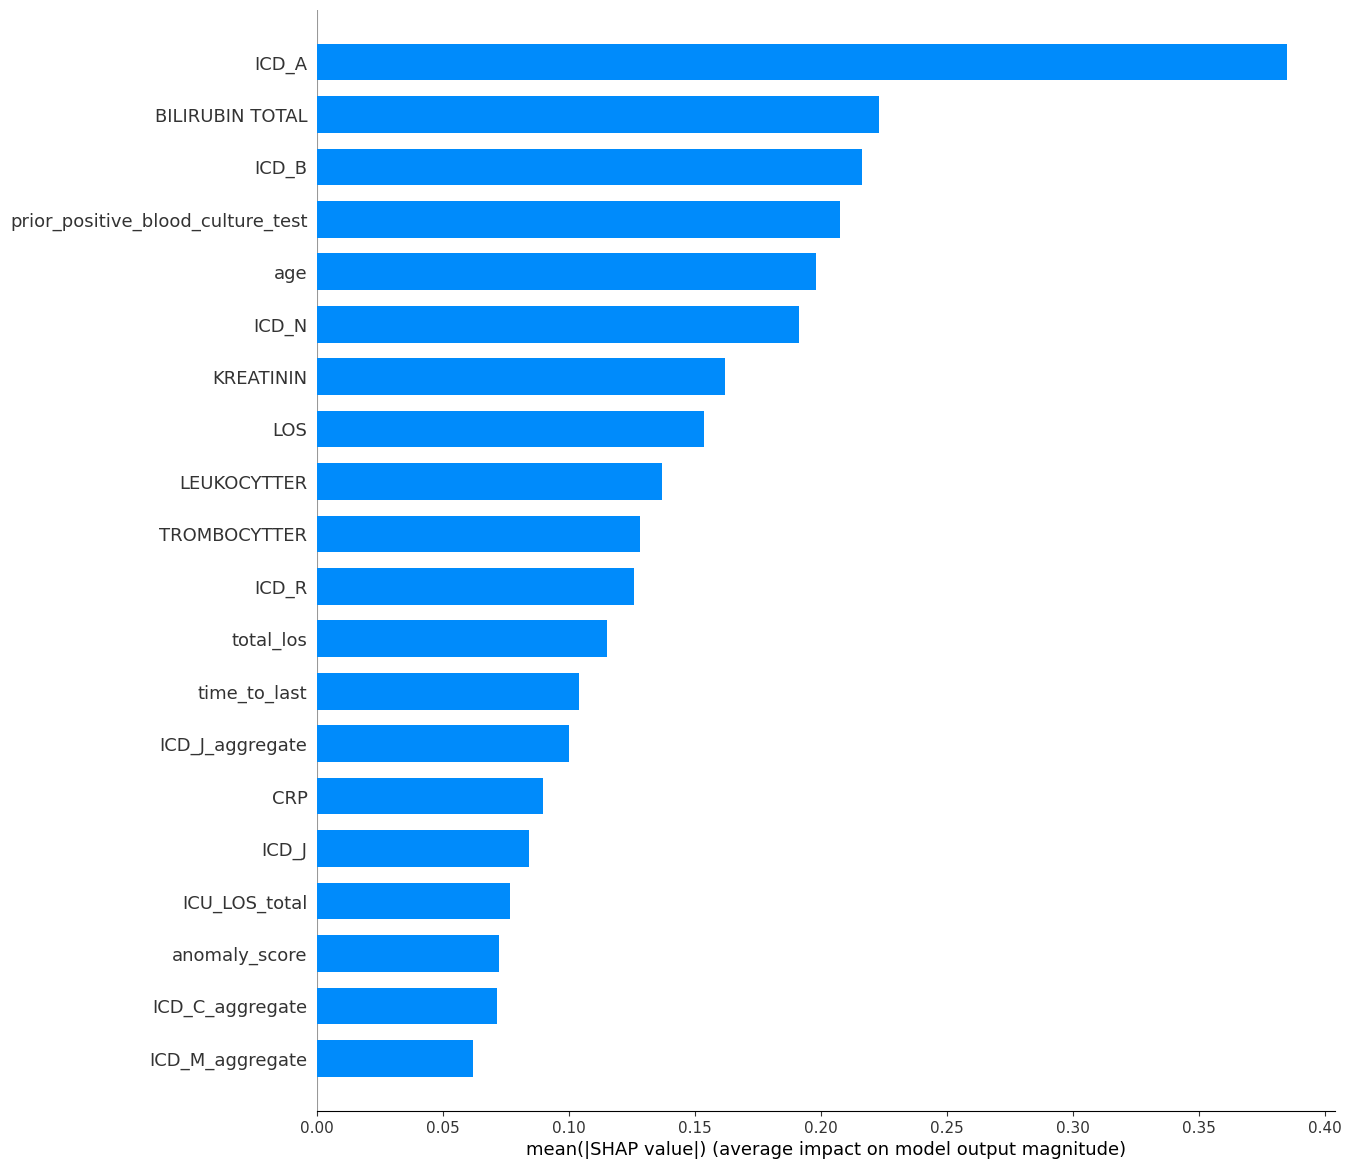

In [34]:
# Plot SHAP summary dot plot
shap.summary_plot(shap_values, plot_type = 'bar', features=X_test_xgb_extended, feature_names=feature_names, show = False,)
# Save the plot as a high-quality PNG file
plt.gcf().set_size_inches(18, 12)  # Adjust the size as needed

plt.savefig("shap_summary_plot_bar.png", bbox_inches='tight', dpi=300)

Adjusting Class Weights

In [ ]:
# Adjusting class weights
rf_class_weights = {0: 1, 1: len(y) / sum(y)}

# Training Random Forest with class weights
rf = RandomForestClassifier(class_weight=rf_class_weights, random_state=42)
rf.fit(X_train_xgb_extended, y_train_xgb)

# Predictions
y_pred = rf.predict(X_test_xgb_extended)

# Metrics
precision = precision_score(y_test_xgb, y_pred)
recall = recall_score(y_test_xgb, y_pred)
f1 = f1_score(y_test_xgb, y_pred)

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

Precision: 0.6881720430107527, Recall: 0.06009389671361502, F1-Score: 0.11053540587219343


Applying SMOTE

In [47]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_xgb_extended, y_train_xgb)

In [48]:

xgb_model = XGBClassifier(scale_pos_weight=class_ratio, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_resampled, y_resampled)
y_pred_xgb = xgb_model.predict(X_test_xgb_extended)

lgb_model = LGBMClassifier(scale_pos_weight=class_ratio)
lgb_model.fit(X_resampled, y_resampled)
y_pred_lgb = lgb_model.predict(X_test_xgb_extended)

cat_model = CatBoostClassifier(scale_pos_weight=class_ratio, verbose=0)
cat_model.fit(X_resampled, y_resampled)
y_pred_cat = cat_model.predict(X_test_xgb_extended)

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_nn.fit(X_resampled, y_resampled, epochs=10, batch_size=32)
y_pred_nn = model_nn.predict(X_test_xgb_extended)

log_reg = LogisticRegression()
log_reg.fit(X_resampled, y_resampled)
y_pred_log = log_reg.predict(X_test_xgb_extended)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)
y_pred_rf = rf_model.predict(X_test_xgb_extended)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 44698, number of negative: 44698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.724111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32995
[LightGBM] [Info] Number of data points in the train set: 89396, number of used features: 165
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Epoch 1/10
2794/2794 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9900 - loss: 0.0328
Epoch 2/10
2794/2794 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9909 - loss: 0.0302
Epoch 3/10
2794/2794 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9914 - loss: 0.0296
Epoch 4/10
2794/2794 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9931 - loss: 0.0254
Epoch 5/10
2794/2794 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9917 - loss: 0.0316
Epoch 6/10
2794/2794 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9921 - loss: 0.0275
Epoch 7/10
2794/2794 ━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
y_scores_xgb = xgb_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_lgb = lgb_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_cat = cat_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_rf = rf_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_nn = model_nn.predict(X_test_xgb_extended).ravel()
y_scores_log = log_reg.predict_proba(X_test_xgb_extended)[:, 1]


print("\nLightGBM Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_lgb, y_scores_lgb)

print("\nCatBoost Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_cat, y_scores_cat)

# For Neural Network, convert predictions to binary first (assuming threshold of 0.5)
y_pred_nn_binary = np.round(y_pred_nn).astype(int).flatten()
print("\nNeural Network Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_nn_binary, y_scores_nn)

print("\nLogistic Regression Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_log, y_scores_log)


print("\nRandom Forest Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_rf, y_scores_rf)


print("XGBoost Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_xgb, y_scores_xgb)

print("\nLogistic Regression Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_log, y_scores_log)


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

LightGBM Model Evaluation:

CatBoost Model Evaluation:

Neural Network Model Evaluation:

Logistic Regression Model Evaluation:

Random Forest Model Evaluation:
XGBoost Model Evaluation:

Logistic Regression Model Evaluation:


(0.7450739923146105,
 0.20011685655857436,
 0.6431924882629108,
 0.30525846702317294,
 0.7599455590789947,
 0.3110739587802842,
 0.7547913308257209)

Ensemble Techniques

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

# Define base models
clf1 = RandomForestClassifier(class_weight=rf_class_weights, random_state=42)
clf2 = LogisticRegression(class_weight='balanced', random_state=42)
clf3 = SVC(class_weight='balanced', probability=True, random_state=42)

# Voting Classifier
eclf = VotingClassifier(estimators=[
    ('rf', clf1), ('lr', clf2), ('svc', clf3)], voting='soft')

# Train Voting Classifier
eclf.fit(X_train_xgb_extended, y_train_xgb)

# Predictions
y_pred_ensemble = eclf.predict(X_test_xgb)

# Metrics
precision_ensemble = precision_score(y_test_xgb, y_pred_ensemble)
recall_ensemble = recall_score(y_test_xgb, y_pred_ensemble)
f1_ensemble = f1_score(y_test_xgb, y_pred_ensemble)

print(f"Precision (Ensemble): {precision_ensemble}, Recall (Ensemble): {recall_ensemble}, F1-Score (Ensemble): {f1_ensemble}")


In [ ]:
# With SMOTE
# Define base models
clf1 = RandomForestClassifier(class_weight=rf_class_weights, random_state=42)
clf2 = LogisticRegression(class_weight='balanced', random_state=42)
clf3 = SVC(class_weight='balanced', probability=True, random_state=42)

# Voting Classifier
eclf = VotingClassifier(estimators=[
    ('rf', clf1), ('lr', clf2), ('svc', clf3)], voting='soft')

# Train Voting Classifier
eclf.fit(X_resampled, y_resampled)

# Predictions
y_pred_ensemble = eclf.predict(X_test_xgb)

# Metrics
precision_ensemble = precision_score(y_test_xgb, y_pred_ensemble)
recall_ensemble = recall_score(y_test_xgb, y_pred_ensemble)
f1_ensemble = f1_score(y_test_xgb, y_pred_ensemble)

print(f"Precision (Ensemble): {precision_ensemble}, Recall (Ensemble): {recall_ensemble}, F1-Score (Ensemble): {f1_ensemble}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
